## This Notebook is tasked with learning the kernel from some pinhole data. 
#### We do it in two stages. First we apply an affine transform model to get the kernel in the right location. Then we make regions of the kernel trainable and do further training. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
from models.custom.modules import *
import forward.fourier.method as fwd

from forward.fourier.kernel_creator import *
import scipy.ndimage
from skimage.transform import rotate

from skimage.feature import peak_local_max
from scipy.ndimage import center_of_mass,shift

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")




%load_ext autoreload
%autoreload 2
device = 'cuda:1'

desired_range = [750,850]
desired_channels = 25

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40


In [2]:
%reload_ext autoreload

## Go from nograting cube to grating cube with grad descent


In [3]:
dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20231211NoGrating/'


measurement = torch.load(dir + 'image.pt').to(torch.float32).to(device).unsqueeze(0).unsqueeze(0)

# mask_funda_wl = mask_nograting_cube[:,:,100:600,1000:1500]

# mask_funda = mask_funda_wl.sum(1).unsqueeze(1)


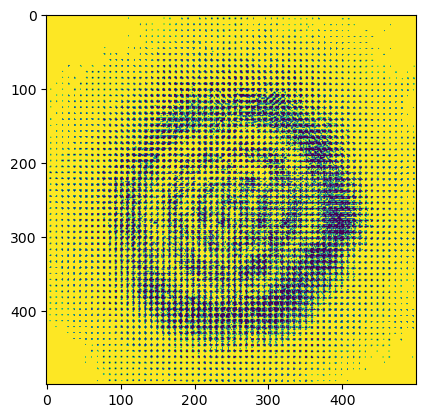

In [4]:
plt.imshow((measurement==0)[0,0].to('cpu').numpy())

In [5]:
peaks = peak_local_max(measurement[0,0].cpu().numpy(), min_distance=6,threshold_rel=0.1)

In [6]:
boxsize = 10


com_peaks = np.zeros((len(peaks),2),dtype=np.float32)
extracted_peaks = np.zeros((len(peaks), boxsize,boxsize))
simulated_peaks = np.zeros_like(extracted_peaks)
simulated_peaks[:,boxsize//2-1:boxsize//2+1,boxsize//2-1:boxsize//2+1] =1

kernelsize = 9

psfs = np.zeros((len(peaks),kernelsize,kernelsize))

for n,peak in enumerate(peaks):
    print(n/len(peaks),end='\r')

    extracted_peaks[n] = measurement[0,0,peak[0]-boxsize//2:peak[0]+boxsize//2,peak[1]-boxsize//2:peak[1]+boxsize//2].cpu().numpy()
    thresholded = extracted_peaks[n].copy()
    thresholded[thresholded<0.05*thresholded.max()] = 0

    com_peaks[n] = np.array(center_of_mass(thresholded)) - (boxsize//2  - 0.5)



    simulated_peaks[n] = shift(simulated_peaks[n],com_peaks[n]  ,order=1)  
    simulated_peaks[n] *=  extracted_peaks[n].mean() / simulated_peaks[n].mean()

    com_peaks[n] += peak


    # psfs[n] = calc_psf_kernel(extracted_peaks[n],simulated_peaks[n],kernelsize=kernelsize)




0.015270758823025971 0.01527075882302597


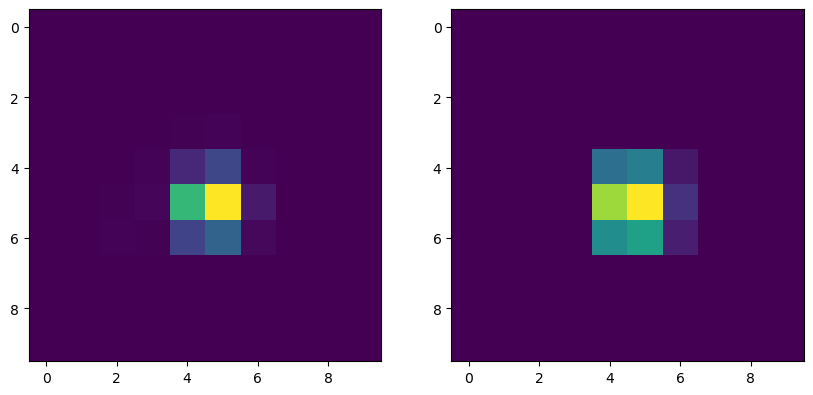

In [7]:

i = np.random.randint(len(peaks))
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(extracted_peaks[i])
ax[1].imshow(simulated_peaks[i])

print(extracted_peaks[i].mean(),simulated_peaks[i].mean())  


### CoM Training

Lets begin with a map of 2d mask pixels. The model is allowed to rotate them and shift them in order to match the data as best as possible.

In [8]:
boxsize = 8

from scipy.ndimage import center_of_mass,shift
CoMs = np.zeros((len(peaks),2))
for n,peak in enumerate(peaks):
    print(n/len(peaks),end='\r')
    thresholded = measurement[0,0,peak[0]-boxsize//2:peak[0]+boxsize//2+1,peak[1]-boxsize//2:peak[1]+boxsize//2+1].cpu().numpy()

    CoMs[n] = np.array(center_of_mass(thresholded)) - (boxsize//2  - 0.5)

    CoMs[n] += peak

In [9]:
CoMs.shape

(2004, 2)

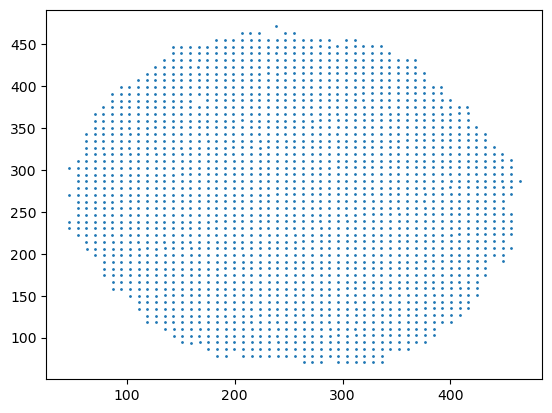

In [10]:
plt.scatter(CoMs[:,1],CoMs[:,0],s=1)    

In [11]:
small_CoMs = CoMs[(CoMs[:,0] > 200 ) & (CoMs[:,0] < 300 ) & (CoMs[:,1] > 200 ) & (CoMs[:,1] < 300 )]

distances = np.zeros((len(small_CoMs),len(small_CoMs)))
for i in range(len(small_CoMs)):
    for j in range(len(small_CoMs)):
        distances[i,j] = np.linalg.norm(small_CoMs[i] - small_CoMs[j])

In [12]:
distances[distances<5] = np.inf

0.0035699399833326326 0.0031308811491465105


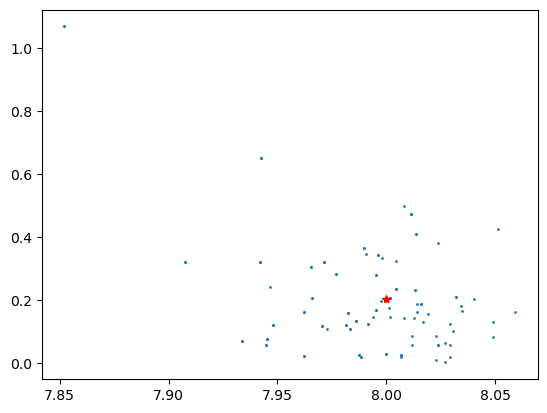

In [13]:
angle = []
distance = []
for i in range(len(small_CoMs)):
    bla = distances[i].argsort()[:1]

    for j in range(1):

        angle.append(np.arctan2((small_CoMs[i,0] - small_CoMs[bla[j],0]) , (small_CoMs[i,1] - small_CoMs[bla[j],1])))
        distance.append(distances[i,bla[j]])

# plt.plot(angle,'*')

angle=np.array(angle)

angle[angle>np.pi/2] -= np.pi/2
angle[angle<0] += np.pi/2
angle[angle<0] += np.pi/2

distance = np.array(distance)[angle<np.pi/4]
angle = angle[angle<np.pi/4]
# plt.plot(angle,'*')

plt.scatter(distance,np.rad2deg(angle),s=1)
print(np.mean(angle),np.std(angle))
plt.plot(8,np.rad2deg(np.mean(angle)),'r*')

angle = np.mean(angle)



In [14]:

init_guess = torch.zeros((1,1,int(measurement.shape[2]),int(measurement.shape[3])),dtype=torch.float32,device=device)
# init_guess = torch.zeros((1,1,int(mask_funda.shape[2] * 2),int(mask_funda.shape[3] * 2)),dtype=torch.float32,device=device)

# peaks = peaks[::3]
# CoMs = CoMs[::3]

# peak = peaks[0]

# i,j = peak
# while i > 0:
#     while j>0:
#         init_guess[:,:,i-1:i+1,j-1:j+1] = 1
#         j -= 8
#     j = peak[1]
#     while j < init_guess.shape[-1]:
#         init_guess[:,:,i-1:i+1,j-1:j+1] = 1
#         j += 8
#     j = peak[1]


#     i -= 8

# i,j = peak
# while i < init_guess.shape[-2]:
#     while j>0:
#         init_guess[:,:,i-1:i+1,j-1:j+1] = 1
#         j -= 8
#     j = peak[1]
#     while j < init_guess.shape[-1]:
#         init_guess[:,:,i-1:i+1,j-1:j+1] = 1
#         j += 8
#     j = peak[1]
#     i += 8
i = 0
while  i < init_guess.shape[-2]:
    j=0
    while  j < init_guess.shape[-1]:
        init_guess[:,:,i+3:i+5,j+3:j+5] = 1
        j+=8
    i+=8




# init_guess[:,:,peaks[0,0] - 1:peaks[0,0]+1,peaks[0,1]-1:peaks[0,1]+1] = 1

In [15]:
kernelsize = 9

regions = np.zeros((len(small_CoMs),2,2))

regions[:,0,0] = (small_CoMs[:,0] - kernelsize//2).astype(int)
regions[:,0,1] = (small_CoMs[:,0] + kernelsize//2).astype(int)
regions[:,1,0] = (small_CoMs[:,1] - kernelsize//2).astype(int)
regions[:,1,1] = (small_CoMs[:,1] + kernelsize//2).astype(int)

# regions[:,0] = regions[:,0] - 100
# regions[:,1] = regions[:,1] - 1000

regions = torch.tensor(regions,dtype=torch.int)



In [16]:
# angle = (angle - np.pi/2)

In [17]:
# loss_fn = CenterOfMassLoss(regions,funda_weight=1,intensity_factor=2, channels=mask_grating_cube.shape[1])
CoMLoss = CenterOfMassLoss(regions,funda_weight=1,intensity_factor=1, channels=1)

# model = AffineTransformModel(region = np.array([[[0,init_guess.shape[2]],[0,init_guess.shape[3]]]]),rot = -np.rad2deg(angle),transX=0.07,transY=0.07,scale = False, no_channels = 1, grating=False).to(device)
model = AffineTransformModel(region = np.array([[[0,init_guess.shape[2]],[0,init_guess.shape[3]]]]),rot = -np.rad2deg(angle),transX=0.06,transY=0.06,scale = True, no_channels = 1, grating=False).to(device)

In [18]:
init_guess = init_guess.to(device)

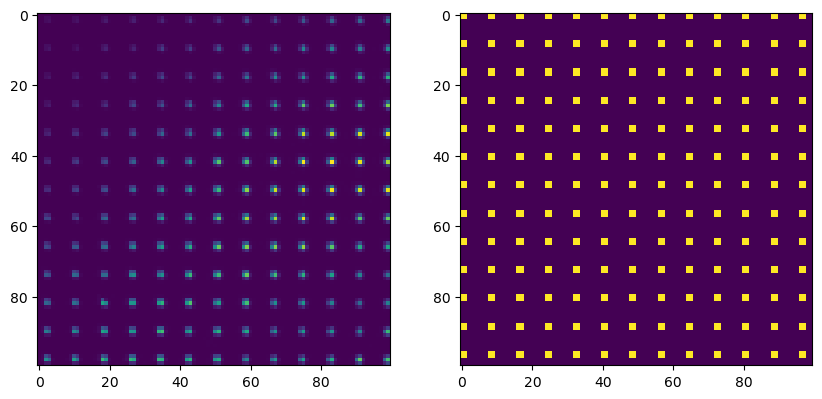

In [19]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(measurement.cpu()[0,0,100:200,100:200])

ax[1].imshow(model(init_guess).detach().cpu()[0,0,100:200,100:200])

In [20]:
# init_guess += 0.0001*torch.rand_like(init_guess)

In [21]:
model(init_guess).shape

torch.Size([1, 1, 500, 500])

In [22]:
yhat = model(init_guess)

#take center of yhat according to shape
# yhat = yhat[:,:,yhat.shape[2]//2-shape[0]//2:yhat.shape[2]//2+shape[0]//2,yhat.shape[3]//2-shape[1]//2:yhat.shape[3]//2+shape[1]//2]

CoMLoss(yhat,measurement[:,:]).item()

6.524104118347168

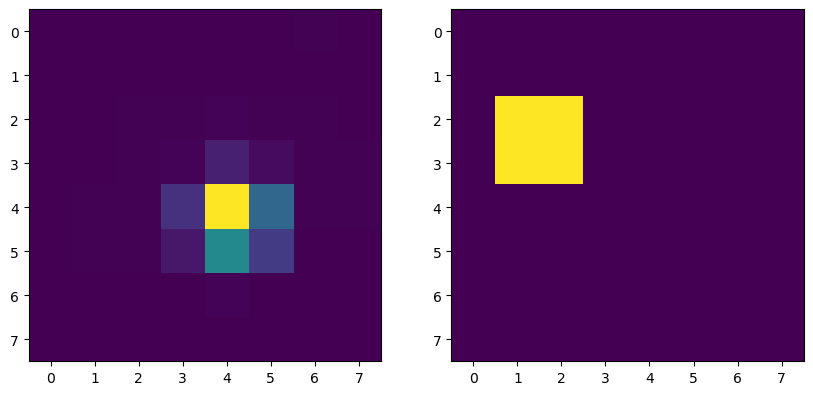

In [23]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

peak = peaks[0]
ax[0].imshow(measurement.cpu()[0,0,peak[0]-boxsize//2:peak[0]+boxsize//2,peak[1]-boxsize//2:peak[1]+boxsize//2])
ax[1].imshow(yhat.detach().cpu()[0,0,peak[0]-boxsize//2:peak[0]+boxsize//2,peak[1]-boxsize//2:peak[1]+boxsize//2])

In [24]:
x = init_guess.to(device)
y = measurement[:,:] * x.mean() / measurement[:,:].mean()
y = y.to(device)

In [25]:
history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['mse'] = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

epochs = 300
start_time_sec = time.time()
num_train_examples = 1

for epoch in range(1, epochs+1):
    torch.cuda.empty_cache()


    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    optimizer.zero_grad()


    adjusted = model(x)
    # adjusted = model(mask_funda)
    # adjusted = yhat[:,:,yhat.shape[2]//2-shape[0]//2:yhat.shape[2]//2+shape[0]//2,yhat.shape[3]//2-shape[1]//2:yhat.shape[3]//2+shape[1]//2]

    
    
    # loss =  loss_fn(adjusted, init_guess)
    loss =  CoMLoss(adjusted, y)

    loss.backward()
    optimizer.step()

    train_loss        = loss.data.item() 





    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}: , train loss: {(train_loss/num_train_examples):5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')



    history['loss'].append(train_loss)


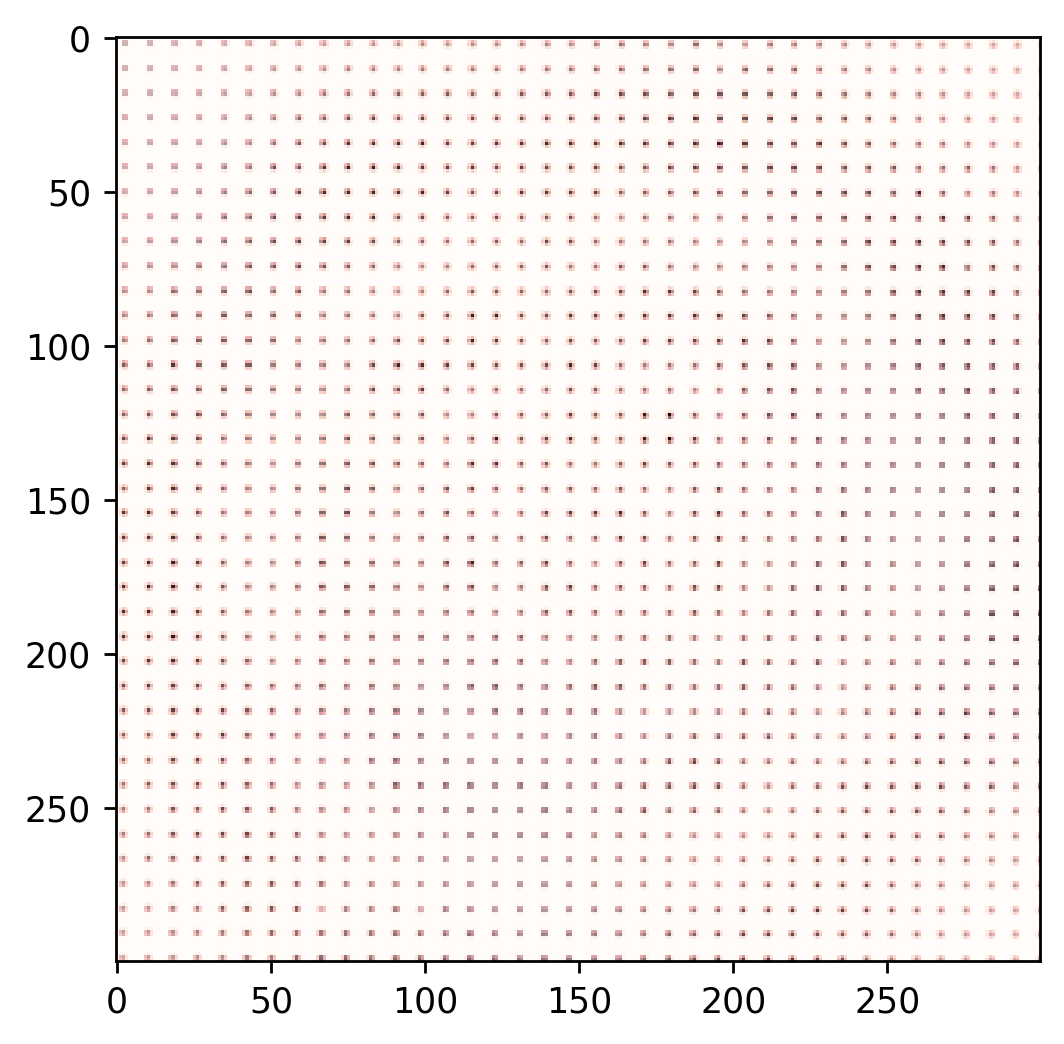

In [26]:
plt.figure(dpi=250)

plt.imshow(y[0,0,100:400,100:400].cpu().detach(),cmap='Greys')
plt.imshow(adjusted[0,0,100:400,100:400].cpu().detach(),alpha=0.3,cmap='Reds')

In [27]:
model2 = AffineTransformModel(region = np.array([[[0,init_guess.shape[2]],[0,init_guess.shape[3]]]]),rot = -np.rad2deg(angle),transX=0.06,transY=0.08,scale = True, no_channels = 1, grating=False).to(device)


theta = model.fill_theta()[0,0].cpu().detach()
theta_inv = torch.inverse(torch.concat((theta,torch.tensor([0,0,1]).unsqueeze(0)),0))[:2]
# theta_inv = torch.inverse(theta)
# theta_inv[0,2] = -model.transX_list[0]
# theta_inv[1,2] = -model.transY_list[0]

model2.set_theta(theta_inv.unsqueeze(0))

inverse_y = model2(y)

/home/s/Sunny.Howard/SCI/models/custom/model.py:456: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.transX_list = nn.Parameter(torch.tensor(theta[:,0,2]))
/home/s/Sunny.Howard/SCI/models/custom/model.py:457: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.transY_list = nn.Parameter(torch.tensor(theta[:,1,2]))
/home/s/Sunny.Howard/SCI/models/custom/model.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.scaleX_list = nn.Parameter(torch.tensor(theta[:,0,:2]))
/home/s/Sunny.Howard/SCI/models/custom/model.py:459: UserWarning: 

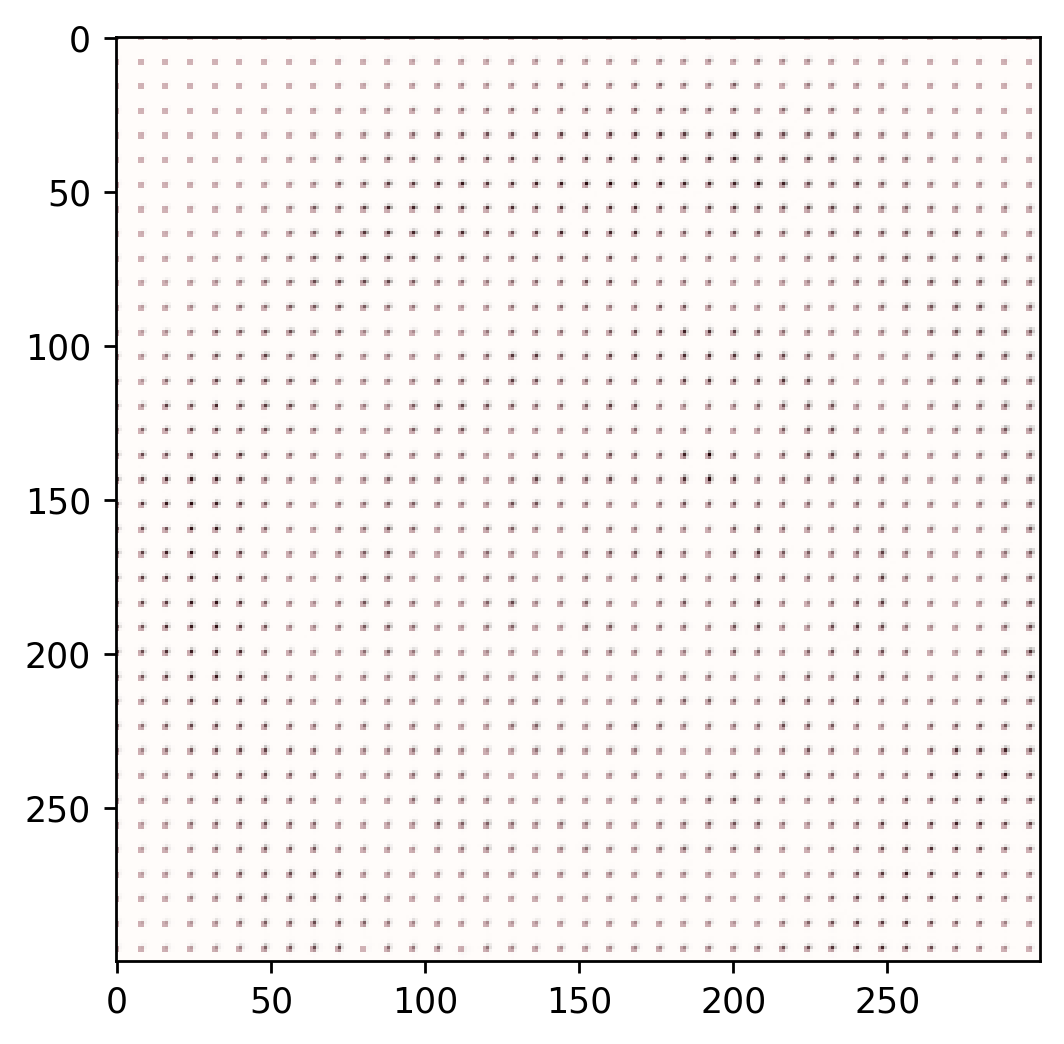

In [28]:
plt.figure(dpi=250)

plt.imshow(inverse_y[0,0,100:400,100:400].cpu().detach(),cmap='Greys')
plt.imshow(x[0,0,100:400,100:400].cpu().detach(),alpha=0.3,cmap='Reds')

In [29]:
intensity_mask = torch.zeros((1,1,int(np.ceil(500/8)),int(np.ceil(500/8)))).to(device)#)torch.zeros_like(affine_guess)
for i in range(500//8):
    for j in range(500//8):
        intensity_mask[:,:,i,j] = inverse_y[:,:,i*8:i*8+8,j*8:j*8+8].sum()/4

up_intensity_mask = torch.nn.functional.interpolate(intensity_mask,scale_factor=8,mode='nearest')[:,:,:500,:500]


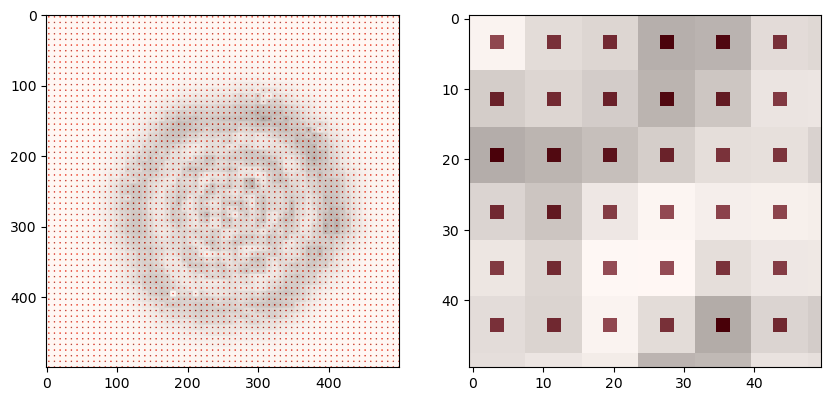

In [30]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(init_guess[0,0].cpu(),cmap='Reds')
ax[0].imshow(up_intensity_mask[0,0].cpu().detach(),alpha=0.3,cmap='Greys')
ax[1].imshow(init_guess[0,0,200:250,200:250].cpu(),cmap='Reds')
ax[1].imshow(up_intensity_mask[0,0,200:250,200:250].cpu().detach(),alpha=0.3,cmap='Greys')


(100.0, 250.0)

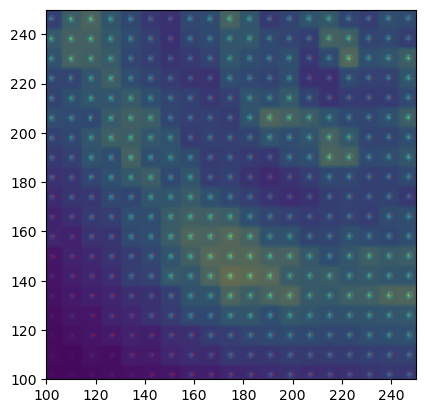

In [31]:
plt.imshow(model(up_intensity_mask)[0,0,].cpu().detach())
# plt.imshow(model(init_guess)[0,0,100:200,100:200].cpu().detach(),alpha=0.5)
plt.imshow(y[0,0,].cpu().detach(),alpha=0.5)
plt.scatter(CoMs[:,1],CoMs[:,0],s=.3,alpha=0.5,c='r')

plt.xlim(100,250)
plt.ylim(100,250)

In [32]:
affine_guess = model(up_intensity_mask * x)

# affine_guess *= mask

print('loss',nn.MSELoss()(affine_guess,y))

theta = model.fill_theta()[0]

grid = nn.functional.affine_grid(theta,init_guess.shape)

torch.save(grid,dir+'affine_grid.pt')

loss tensor(0.0106, device='cuda:1', grad_fn=<MseLossBackward0>)


/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [33]:
# print(f'original: {-angle};     final: {model.rot_list.data[0].cpu().numpy()},' )

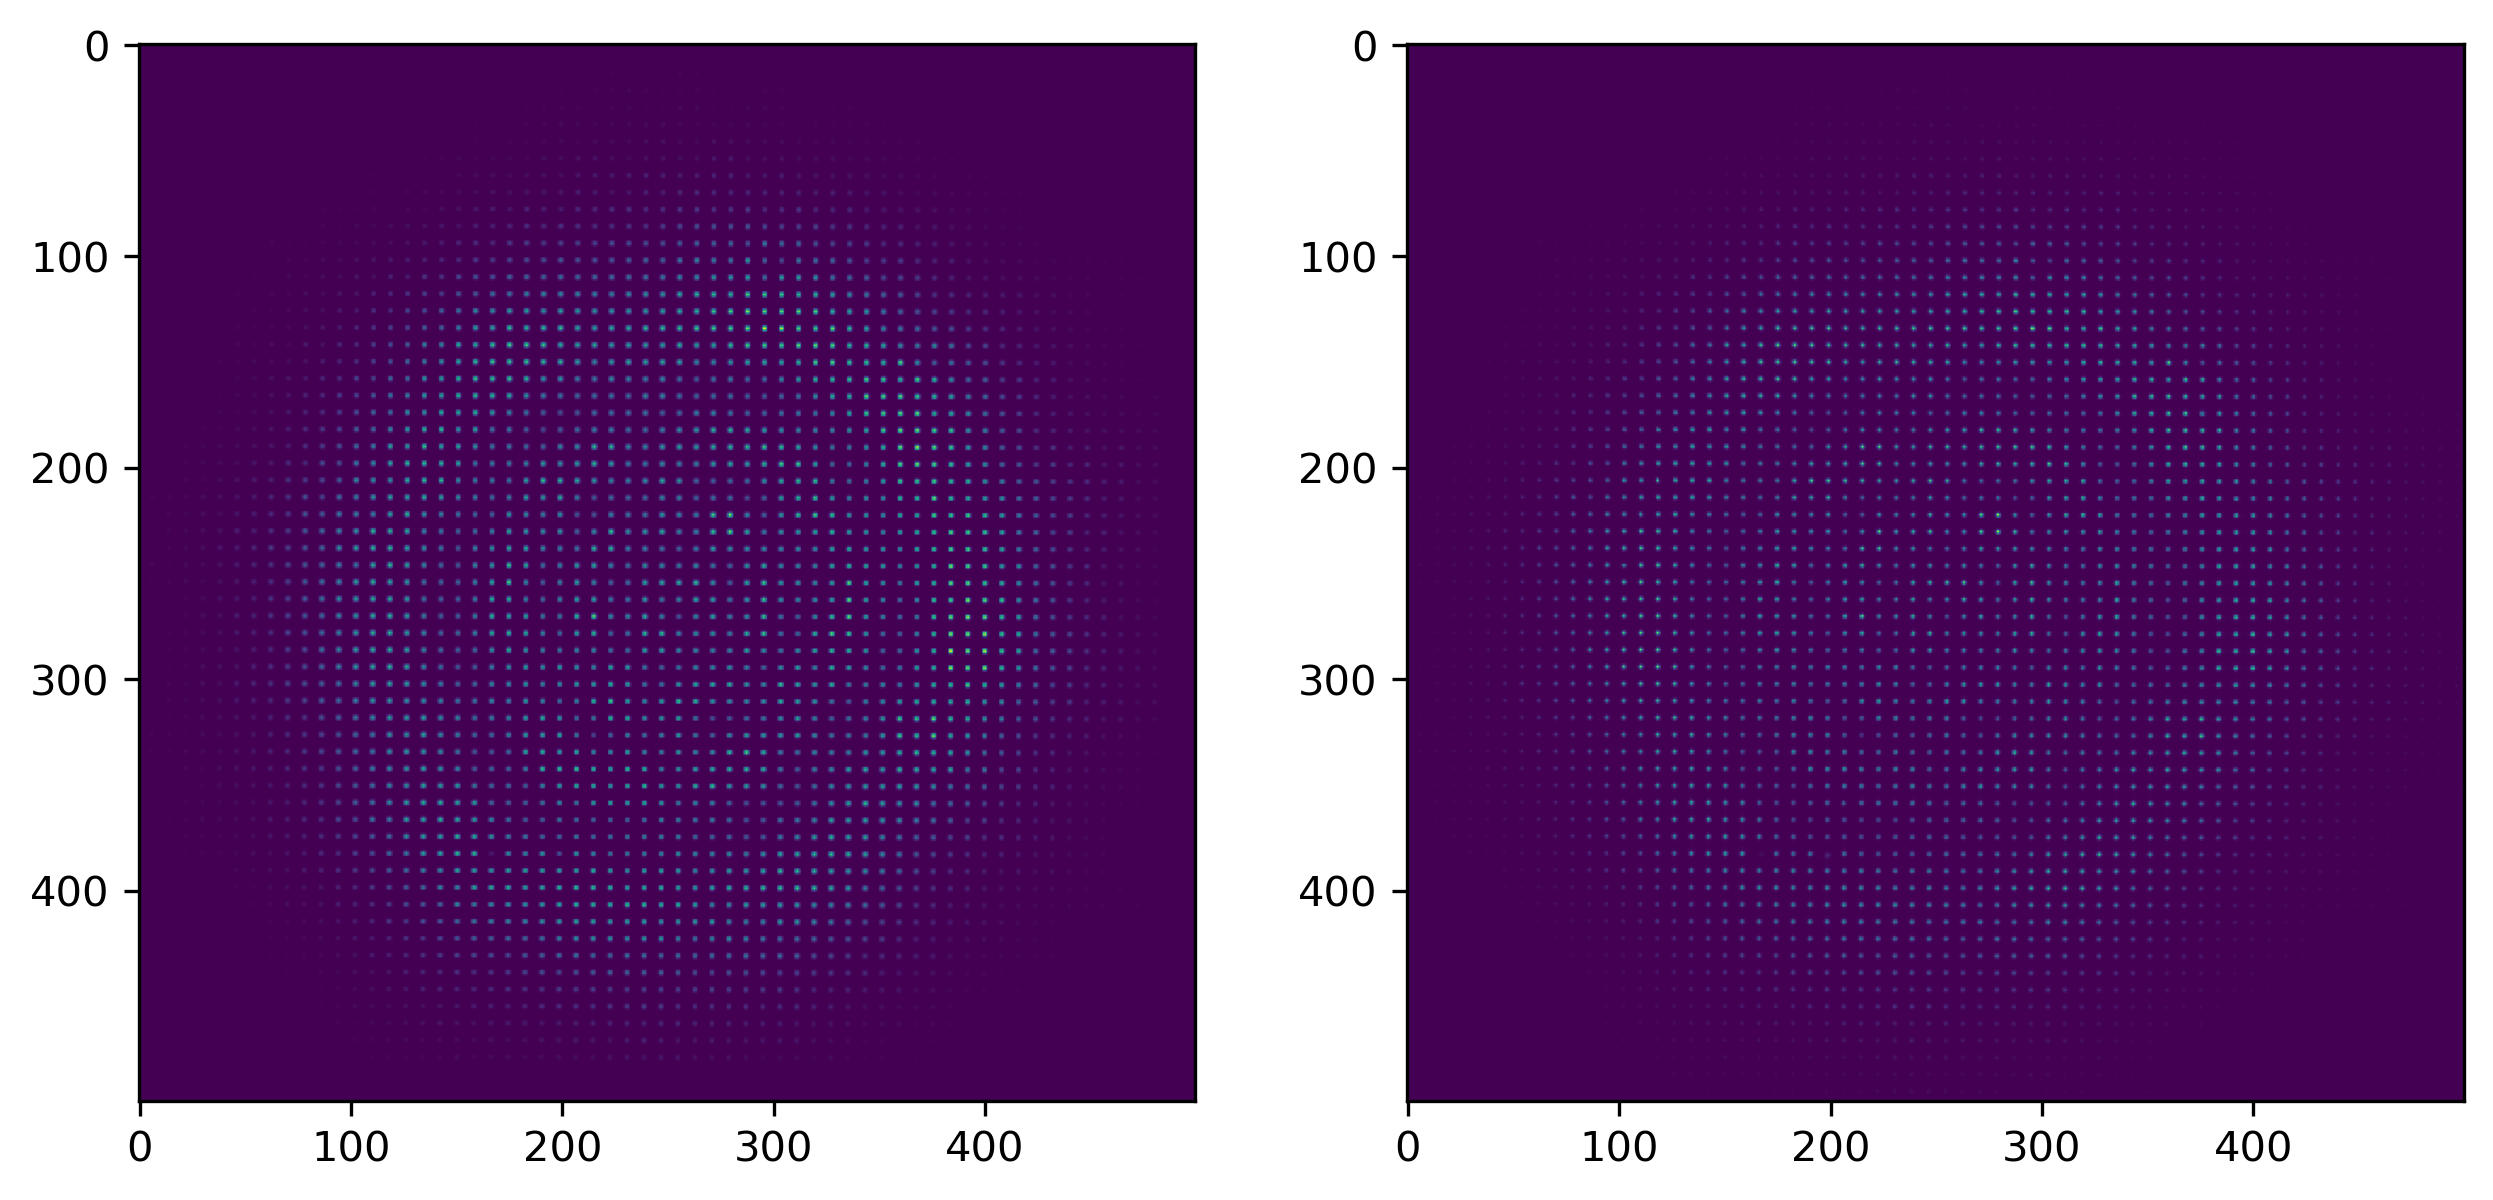

In [34]:
fig,ax = plt.subplots(1,2,figsize=(10,5),dpi=300)
ax[0].imshow((affine_guess).detach().cpu()[0,0])
ax[1].imshow(y.detach().cpu()[0,0])

#### Now we make grid trainable along with additional warp mask

In [35]:
def hessian(map,norm=2):
    deriv_xx = (1/90)*torch.roll(map,3,dims=2) -(3/20)*torch.roll(map,2,dims=2) + (3/2)*torch.roll(map,1,dims=2) - (49/18) * map + (3/2)*torch.roll(map,-1,dims=2) - (3/20)*torch.roll(map,-2,dims=2) + (1/90)*torch.roll(map,-3,dims=2)
    deriv_yy = (1/90)*torch.roll(map,3,dims=3) -(3/20)*torch.roll(map,2,dims=3) + (3/2)*torch.roll(map,1,dims=3) - (49/18) * map + (3/2)*torch.roll(map,-1,dims=3) - (3/20)*torch.roll(map,-2,dims=3) + (1/90)*torch.roll(map,-3,dims=3)
    deriv_xy = (1/90)*torch.roll(map,(3,3),dims=(2,3)) -(3/20)*torch.roll(map,(2,2),dims=(2,3)) + (3/2)*torch.roll(map,(1,1),dims=(2,3)) - (49/18) * map + (3/2)*torch.roll(map,(-1,-1),dims=(2,3)) - (3/20)*torch.roll(map,(-2,-2),dims=(2,3)) + (1/90)*torch.roll(map,(-3,-3),dims=(2,3))
    deriv_yx = (1/90)*torch.roll(map,(3,-3),dims=(2,3)) -(3/20)*torch.roll(map,(2,-2),dims=(2,3)) + (3/2)*torch.roll(map,(1,-1),dims=(2,3)) - (49/18) * map + (3/2)*torch.roll(map,(-1,1),dims=(2,3)) - (3/20)*torch.roll(map,(-2,2),dims=(2,3)) + (1/90)*torch.roll(map,(-3,3),dims=(2,3))

    deriv_xx = deriv_xx[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)
    deriv_yy = deriv_yy[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)
    deriv_xy = deriv_xy[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)
    deriv_yx = deriv_yx[:,:,3:-3,3:-3]/ torch.mean(torch.abs(map),dim=(2,3)).unsqueeze(2).unsqueeze(3)

    all_derivs = torch.concat([deriv_xx,deriv_xy,deriv_yx,deriv_yy],dim=0)

    reg_loss = torch.norm(all_derivs,p=norm) / all_derivs.numel()
    return reg_loss
peaks = peak_local_max(measurement[0,0].cpu().numpy(), min_distance=6,threshold_rel=0.1)


In [108]:
class propagator(nn.Module):
    def __init__(self, upsample, lamda, n_spotsx,n_spotsy, proptype = 'points'):
        super(propagator, self).__init__()
        '''
        type can be:'pos' - position encoding
                    'regularised' 
        '''

        self.proptype = proptype

        lamda = lamda * 1e6
        px_size = 3.45e-6 * 1e6

        x_min = y_min = -4*px_size
        x_max = y_max = 4*px_size
        dx_per_px = dy_per_px = upsample

        dx = dy = px_size / dx_per_px

        x0 = torch.linspace(x_min, x_max, int((x_max - x_min) / dx) , device=device)-dx/2
        y0 = torch.linspace(x_min, x_max, int((x_max - x_min) / dx) , device=device)-dx/2

        self.dx = dx
        self.dy = dy
        self.k = 2 * torch.tensor(torch.pi / lamda)


        if proptype == 'points':
            
            l = len(x0)
            x0 = x0[3*l//8:5*l//8]
            
            self.xsquared = (x0**2).unsqueeze(0).unsqueeze(0)


            self.z = nn.Parameter(torch.abs(torch.rand((n_spotsx,n_spotsy,1)) - .5) * 50)
        elif proptype == 'fourier':
            x0 = x0.unsqueeze(-1)
            y0 = y0
            self.xsquared_ysquared = (x0**2 + y0**2).unsqueeze(0).unsqueeze(0)
            self.z = nn.Parameter(torch.abs(torch.rand((n_spotsx,n_spotsy,1,1)) - .5) * 50)

        self.lamda = lamda


    def forward(self, E):
        if self.proptype == 'points':
            I_z = self.forward_points(E)

            I_0 = torch.abs(E) ** 2

            norm_I_z = I_z * (I_0.sum(dim=(2))/I_z.sum(dim=(2,3))).unsqueeze(-1).unsqueeze(-1)


        elif self.proptype == 'fourier':
            I_z = self.forward_fourier(E)
            I_0 = torch.abs(E) ** 2
            norm_I_z = I_z * I_0.sum(dim=(2,3),keepdim=True)/I_z.sum(dim=(2,3),keepdim=True)
        
        return norm_I_z



    def forward_fourier(self, E):
        #given array of size (n_spots, n_spots, 8*upsample, 8*upsample)


        
        
        r = torch.sqrt(self.xsquared_ysquared + self.z ** 2)
        h = - 1/(2*torch.pi) * self.z/r * (1j*self.k - 1/r) * torch.exp(1j * self.k * r) / (r)

        nx,ny = h.shape[2:]

        # h = nn.functional.pad(h,(ny//2,ny//2,nx//2,nx//2),mode='constant',value=0)
        # E = nn.functional.pad(E,(ny//2,ny//2,nx//2,nx//2),mode='constant',value=0)

        h_fft = torch.fft.fft2(h)

        E_fft = torch.fft.fft2(E)
        
        E_z = torch.fft.ifftshift(torch.fft.ifft2(E_fft * h_fft))*self.dx*self.dy

        # E_z = E_z[:,:,nx//2:-nx//2,ny//2:-ny//2]

        I_z = torch.abs(E_z) ** 2

        return I_z
    

    def forward_points(self, E):
        #given array of size (n_spots, n_spots, 8*upsample)

        #for this one we need the distance from each point to every point in the final plane. this means for each spot (60x60x60x60) numbers... probably have to use loop
        
        # E_z = torch.zeros_like(E)
        r = torch.sqrt(self.xsquared + self.z ** 2) 

        i_rows = []
        tic = time.time()
        for i in range(self.z.shape[0]):
            j_rows = []
            for j in range(self.z.shape[1]): #each spot
                kernel = torch.exp(1j * self.k * r[i:i+1,j:j+1]) / (r[i:i+1,j:j+1]**2)
                # E_z[i,j] = nn.functional.conv1d(E[i:i+1,j:j+1], kernel, padding='same')
                # tic = time.time()
 
                j_rows.append(nn.functional.conv1d(E[i:i+1,j:j+1], kernel, padding='same') )
                # toc = time.time()
                # print(toc-tic)

            i_rows.append(torch.concat(j_rows,dim=1))
        
        E_z = torch.concat(i_rows,dim=0)
        

        # tic = time.time()
        E_z = torch.einsum("abi,abj->abij",E_z,E_z)
        # toc = time.time()
        # print(toc-tic)
        I_z = torch.abs(E_z) ** 2
        return I_z

        
upsample = 5
prop = propagator(upsample, 800e-9, n_spotsx=20,n_spotsy=1,proptype='fourier').to(device)


E0 = torch.zeros((20,1,8*upsample,8*upsample),dtype=torch.complex64).to(device)
E0[:,:,3*upsample:5*upsample,3*upsample:5*upsample] = 1

# E0 = torch.zeros((10,1,8*upsample),dtype=torch.complex64).to(device)
# E0[:,:,3*upsample:5*upsample] = 1

# prop.z.data[...,0] = torch.linspace(-1e1,1e1,10,device=device).unsqueeze(-1)
prop.z.data[...,0,0] = torch.linspace(-6e1,6e1,20,device=device).unsqueeze(-1)

I0 = (torch.abs(E0) ** 2).permute(0,2,1,3).reshape(1,1,20*(8*upsample),1*(8*upsample))
# I0 = (torch.abs(E0) ** 2).permute(0,2,1).reshape(1,1,10*(8*upsample))

IZ = prop(E0).permute(0,2,1,3).reshape(1,1,20*(8*upsample),1*(8*upsample))

In [106]:
3e-4 * 3600

1.0799999999999998

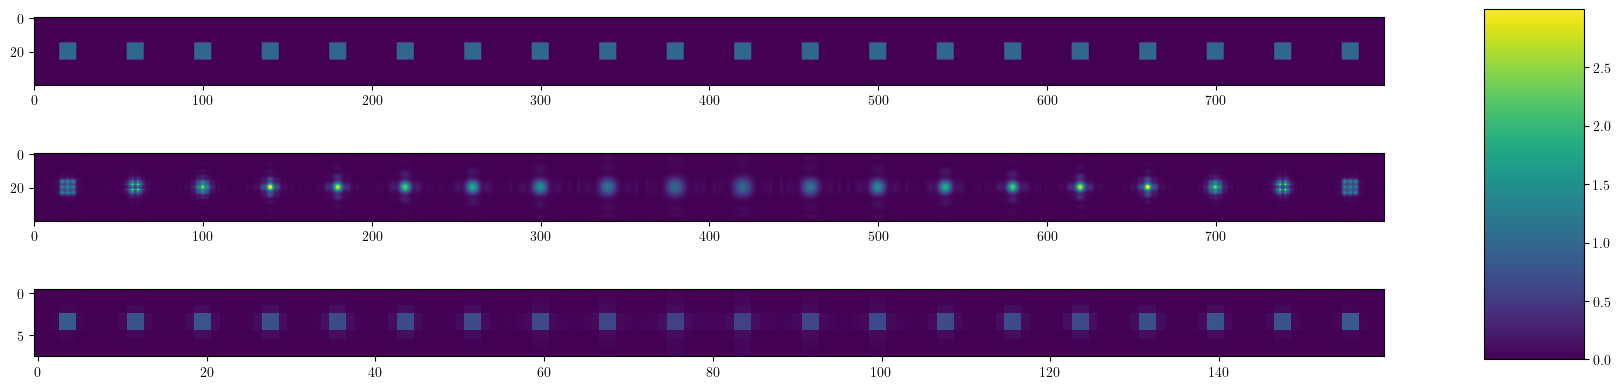

In [111]:
fig,ax = plt.subplots(3,1,figsize=(20,5))
vmax = np.max((torch.max(IZ).cpu().detach().numpy() ,torch.max(I0).cpu().detach().numpy() ))
vmin = np.min((torch.min(IZ).cpu().detach().numpy() ,torch.min(I0).cpu().detach().numpy() ))


# ax[0].plot(I0[0,0].T.cpu().detach())
ax[0].imshow(I0[0,0].T.cpu().detach(),vmax=vmax,vmin=vmin)

plot1 = ax[1].imshow(IZ[0,0].T.cpu().detach(),vmax=vmax,vmin=vmin)

ax[2].imshow(nn.functional.avg_pool2d(IZ,(upsample,upsample)).squeeze(0).squeeze(0).T.cpu().detach(),vmax=vmax,vmin=vmin)

fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plot1, cax=cbar_ax)
# plt.colorbar(plot1)

In [112]:
upsample = 5

lamda = 800e-9


num_cells = torch.ceil(torch.tensor(init_guess.shape[2:]) / 8).to(int)


prop = propagator(upsample, lamda, n_spotsx=num_cells[0],n_spotsy=num_cells[1], proptype='fourier').to(device)


E0 = torch.zeros((num_cells[0],num_cells[1],8*upsample,8*upsample),dtype=torch.complex64).to(device)
E0[:,:,3*upsample:5*upsample,3*upsample:5*upsample] = 1

# E0 = torch.zeros((num_cells[0],num_cells[1],8*upsample),dtype=torch.complex64).to(device)
# E0[:,:,3*upsample:5*upsample] = 1


I0 = (torch.abs(E0) ** 2).permute(0,2,1,3).reshape(1,1,num_cells[0]*(8*upsample),num_cells[1]*(8*upsample))
# I0 = (torch.abs(E0) ** 2).permute(0,2,1).reshape(1,1,10*(8*upsample))

IZ = prop(E0).permute(0,2,1,3).reshape(1,1,num_cells[0]*(8*upsample),num_cells[1]*(8*upsample))



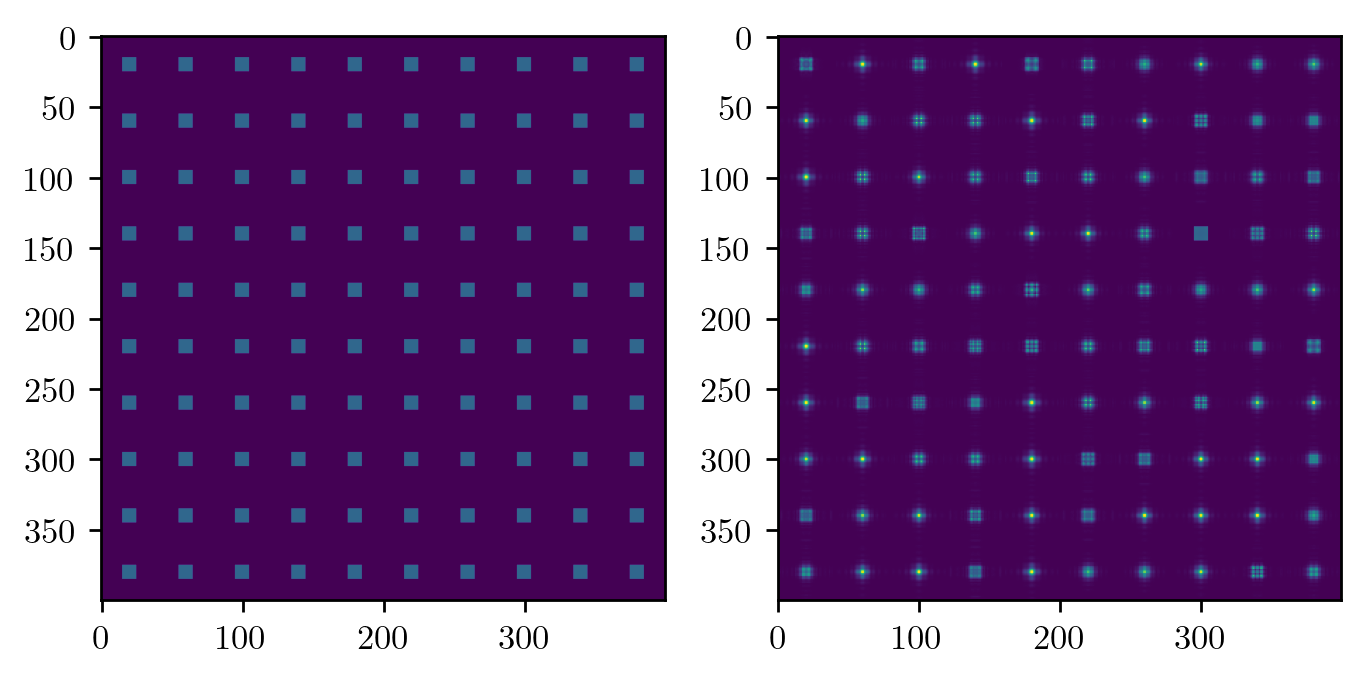

In [113]:
fig,ax = plt.subplots(1,2,dpi=250)

vmax = IZ[0,0,:400,:400].cpu().detach().max()

ax[0].imshow(I0[0,0,:400,:400].cpu().detach(),vmin=0,vmax=vmax)
ax[1].imshow(IZ[0,0,:400,:400].cpu().detach(),vmin=0,vmax=vmax)

In [129]:
lr = 5e-2

history2 = {'tl':[],'mse':[],'reg':[], 'lr':[]}


# Load the affine grid and move it to the device
affine_grid = torch.load(dir+'affine_grid.pt').to(device).detach()

shape = affine_grid.shape

warp_upsample_factor = 4

x_pos = torch.linspace(1, -1, init_guess.shape[2]//warp_upsample_factor)
y_pos = torch.linspace(-1, 1, init_guess.shape[3]//warp_upsample_factor)
x_grid, y_grid = torch.meshgrid(x_pos, y_pos)

init = torch.concat([x_grid.unsqueeze(-1), y_grid.unsqueeze(-1)], dim=-1).unsqueeze(0) * 4 / init_guess.shape[2] #the factor means four pixel shift across image.
init = torch.rand_like(init) * 1e-5



# Move affine_grid to the device, then wrap in nn.Parameter
affine_grid = affine_grid.to(device)
IZ = prop(E0).permute(0,2,1,3).reshape(1,1,num_cells[0]*(8*upsample),num_cells[1]*(8*upsample))[:,:,:500*upsample,:500*upsample]
up_affine = nn.functional.interpolate(affine_grid.permute(0,3,1,2),scale_factor=upsample,mode='bilinear').permute(0,2,3,1)[...,:IZ.shape[2],:IZ.shape[3]].detach()
up_affine = nn.Parameter(up_affine, requires_grad=True)
# affine_grid = nn.Parameter(affine_grid, requires_grad=True)

# Create spatial_warp, move it to the device, then wrap in nn.Parameter
spatial_warp = (init).to(device)
spatial_warp = nn.Parameter(spatial_warp, requires_grad=True)


intensity_mask = intensity_mask.to(device)
intensity_mask = nn.Parameter(intensity_mask, requires_grad=True)

prop = propagator(upsample, lamda, n_spotsx=num_cells[0],n_spotsy=num_cells[1],proptype='fourier').to(device)


conv = nn.Conv2d(1,1,kernel_size=5,padding=2,bias=False).to(device)

shape = y.shape[2:]

epochs = 40000
init_reg_factor =  4e-1

wl = 11
# loss_fn = CoMLoss
loss_fn = torch.nn.MSELoss()

x_up= nn.functional.interpolate(x,scale_factor=upsample,mode='nearest').to(device)[:,:,:500*upsample,:500*upsample]
up_intensity_mask = nn.functional.interpolate(intensity_mask,scale_factor=8*upsample,mode='nearest')[...,:IZ.shape[2],:IZ.shape[3]]#[:,:,:500,:500]

yhat = nn.functional.grid_sample(x_up * up_intensity_mask, up_affine) #  * mask
yhat = nn.functional.avg_pool2d(yhat, upsample)[...,:500,:500]

print(loss_fn(yhat ,y))

all_params =  []
all_params += list(prop.parameters()) 
all_params += [spatial_warp] 
# all_params += [intensity_mask] 
# all_params += [up_affine] 
# all_params += list(conv.parameters())

optimizer = torch.optim.Adam(all_params, lr=lr)


tensor(0.0106, device='cuda:1', grad_fn=<MseLossBackward0>)


/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [132]:

start_time_sec = time.time()
num_train_examples = 1

up_intensity_mask = nn.functional.interpolate(intensity_mask,scale_factor=8*upsample,mode='nearest')[...,:IZ.shape[2],:IZ.shape[3]]#[:,:,:500,:500]

for epoch in range(1, epochs+1):
    torch.cuda.empty_cache()


    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    optimizer.zero_grad()

    IZ = prop(E0).permute(0,2,1,3).reshape(1,1,num_cells[0]*(8*upsample),num_cells[1]*(8*upsample))[:,:,:500*upsample,:500*upsample]

    # IZ_down = nn.functional.avg_pool2d(IZ, upsample)[...,:500,:500]


    # upsampled_warp = nn.functional.interpolate(spatial_warp.permute(0,3,1,2),scale_factor=(upsample*warp_upsample_factor),mode='bilinear').permute(0,2,3,1)[...,:IZ.shape[2],:IZ.shape[3]]

    newgrid = up_affine #+ upsampled_warp


    yhat_up = nn.functional.grid_sample(IZ* up_intensity_mask, newgrid)  # * mask

    yhat = nn.functional.avg_pool2d(yhat_up, upsample)[...,:500,:500]
    # yhat = nn.functional.grid_sample(IZ_down* up_intensity_mask, newgrid)  # * mask

    # yhat = conv(yhat)

    reg =   hessian(torch.abs(torch.fft.fftshift(prop.z.permute(2,3,0,1)))) + hessian(spatial_warp.permute(0,3,1,2)) #+hessian(torch.abs(torch.fft.fftshift(prop.z.permute(2,3,0,1))))
    
    mse = loss_fn(yhat, y)
    loss =  mse + init_reg_factor*reg

    loss.backward()
    optimizer.step()

    train_loss        = loss.data.item() 

    # with torch.no_grad():


    #     conv.weight.data = torch.clamp(conv.weight.data,0,1)

    # reg = 0 



    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g}, train reg: {reg:5.5g}  epoch time: {total_time_sec:5.5g}',end='\r')



    history2['mse'].append(mse.data.item())
    # history2['reg'].append((init_reg_factor*reg).data.item())

KeyboardInterrupt: 

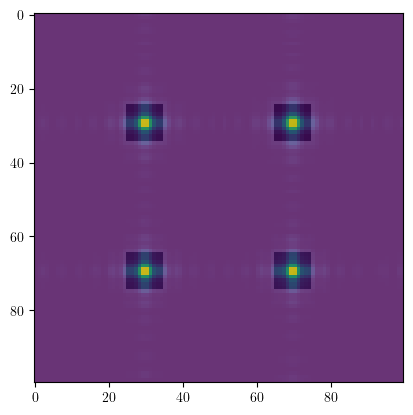

In [133]:
plt.imshow(nn.functional.interpolate(init_guess,scale_factor=upsample)[0,0,110*upsample:130*upsample,110*upsample:130*upsample].cpu().detach(),cmap='Greys')
plt.imshow(IZ[0,0,110*upsample:130*upsample,110*upsample:130*upsample].cpu().detach(),alpha = 0.8)

In [143]:
up_intensity_mask.shape

torch.Size([1, 1, 2500, 2500])

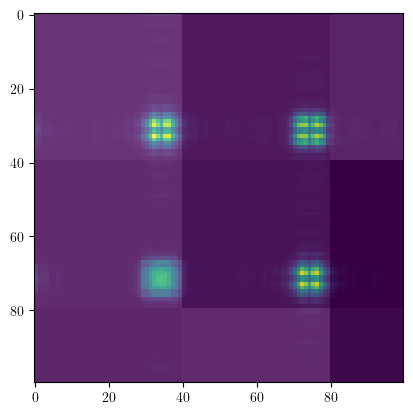

In [144]:
# plt.imshow(nn.functional.interpolate(affine_guess,scale_factor=upsample)[0,0,1000:1100,600:700].cpu().detach(),cmap='Greys')
plt.imshow(up_intensity_mask[0,0,1000:1100,600:700].cpu().detach(),cmap='Greys')
plt.imshow(yhat_up[0,0,1000:1100,600:700].cpu().detach(),alpha = 0.8)


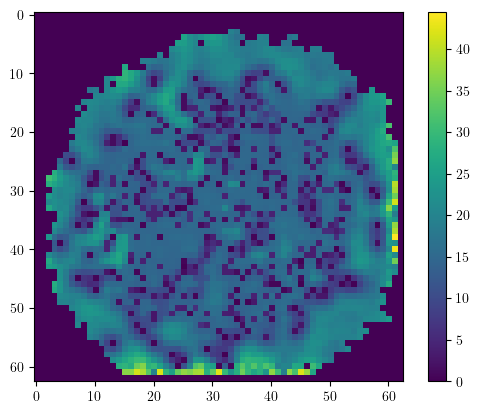

In [145]:
threshed_intensity_mask = intensity_mask > intensity_mask.max() * 0.01

plt.imshow((torch.fft.fftshift(torch.abs(prop.z.data[...,0,0]) )  *threshed_intensity_mask[0,0]) .cpu().detach())
plt.colorbar()

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


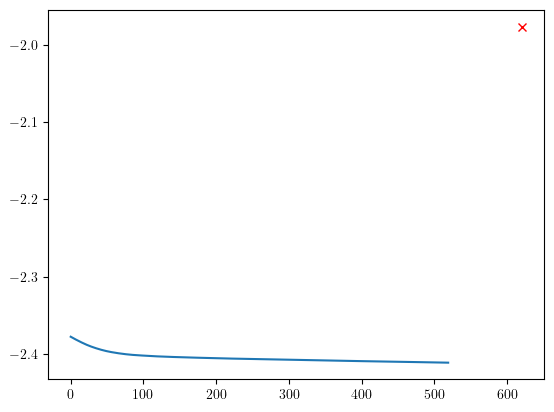

In [146]:
plt.plot(np.log10(history2['mse'][100:]))#[100:])
plt.plot(np.log10(history2['reg'][100:]))#[100:])

halfup_intensity_mask = nn.functional.interpolate(intensity_mask,scale_factor=8,mode='nearest')[:,:,:500,:500]


yhat_affine = nn.functional.grid_sample(x * halfup_intensity_mask, affine_grid)  # * mask
mse = loss_fn(yhat_affine, y)


plt.plot(len(history2['mse']),np.log10(mse.data.item()),'rx')#[100:])

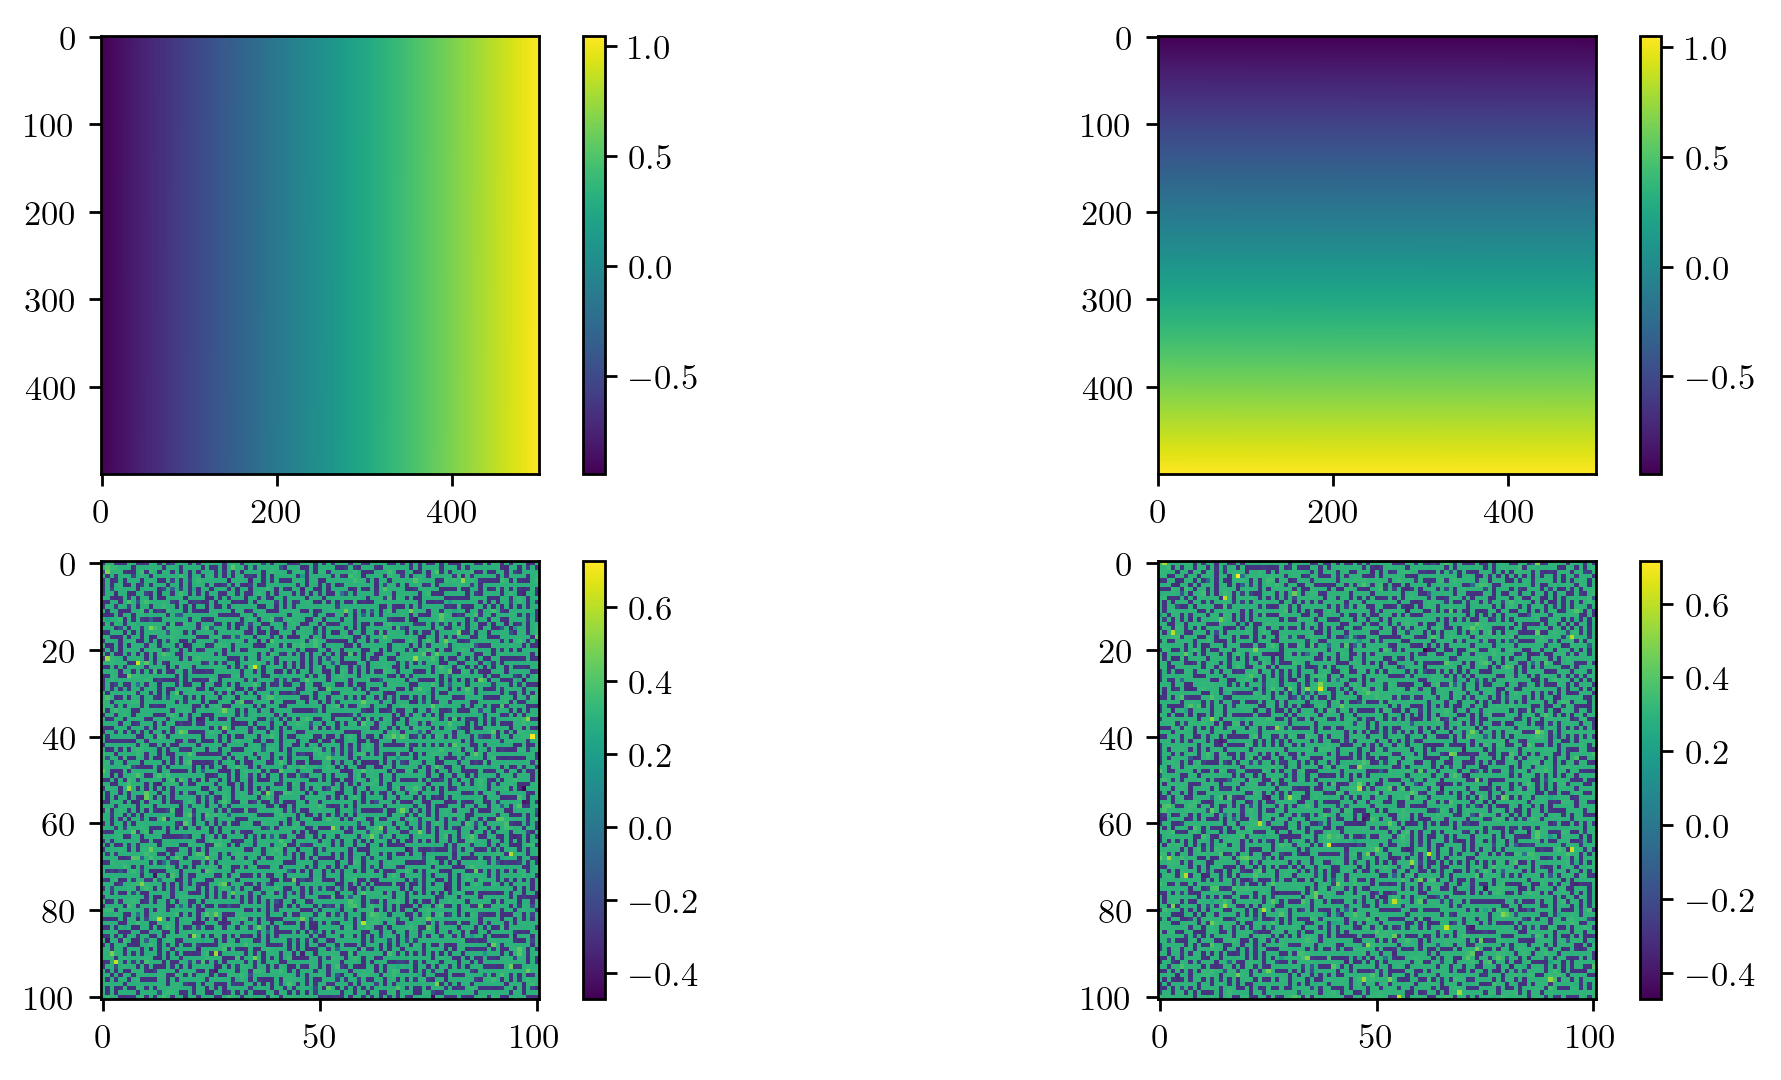

In [147]:
fig,ax = plt.subplots(2,2,figsize=(10,5),dpi=250)
plot1 = ax[0,0].imshow(affine_grid.cpu()[0,...,0].detach())
plt.colorbar(plot1,ax=ax[0,0])
plot2 = ax[0,1].imshow(affine_grid.cpu()[0,...,1].detach())
plt.colorbar(plot2,ax=ax[0,1])


plot3 = ax[1,0].imshow((spatial_warp).cpu()[0,3*warp_upsample_factor:-3*warp_upsample_factor,3*warp_upsample_factor:-3*warp_upsample_factor,0].detach())
plt.colorbar(plot3,ax=ax[1,0])
plot4 = ax[1,1].imshow((spatial_warp).cpu()[0,3*warp_upsample_factor:-3*warp_upsample_factor,3*warp_upsample_factor:-3*warp_upsample_factor,1].detach())
plt.colorbar(plot4,ax=ax[1,1])

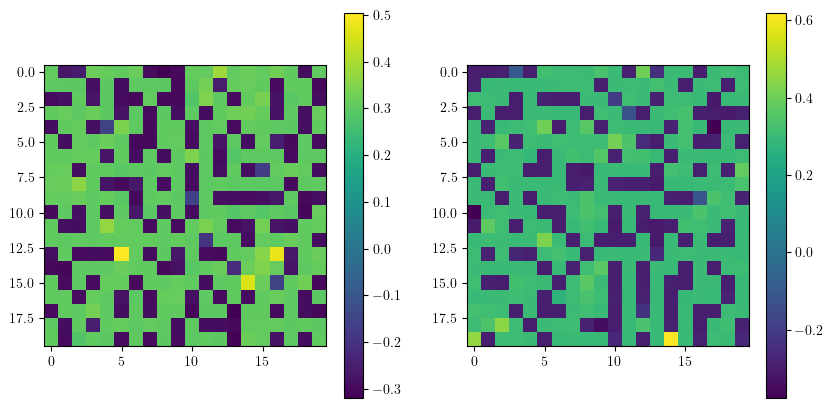

In [148]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
plot3 = ax[0].imshow(spatial_warp.cpu()[0,60:80,60:80,0].detach())
plt.colorbar(plot3,ax=ax[0])
plot4 = ax[1].imshow(spatial_warp.cpu()[0,60:80,60:80,1].detach())
plt.colorbar(plot4,ax=ax[1])

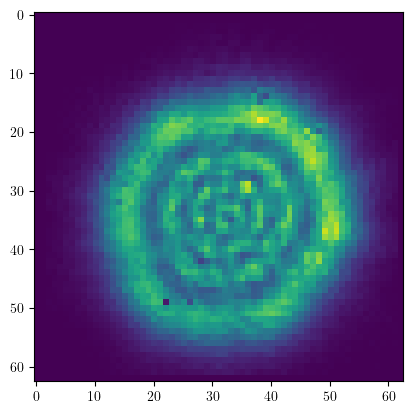

In [149]:
plt.imshow(intensity_mask[0,0].cpu().detach())

Text(0.5, 1.0, '$\\mathbf{u} - \\mathbf{f}$')

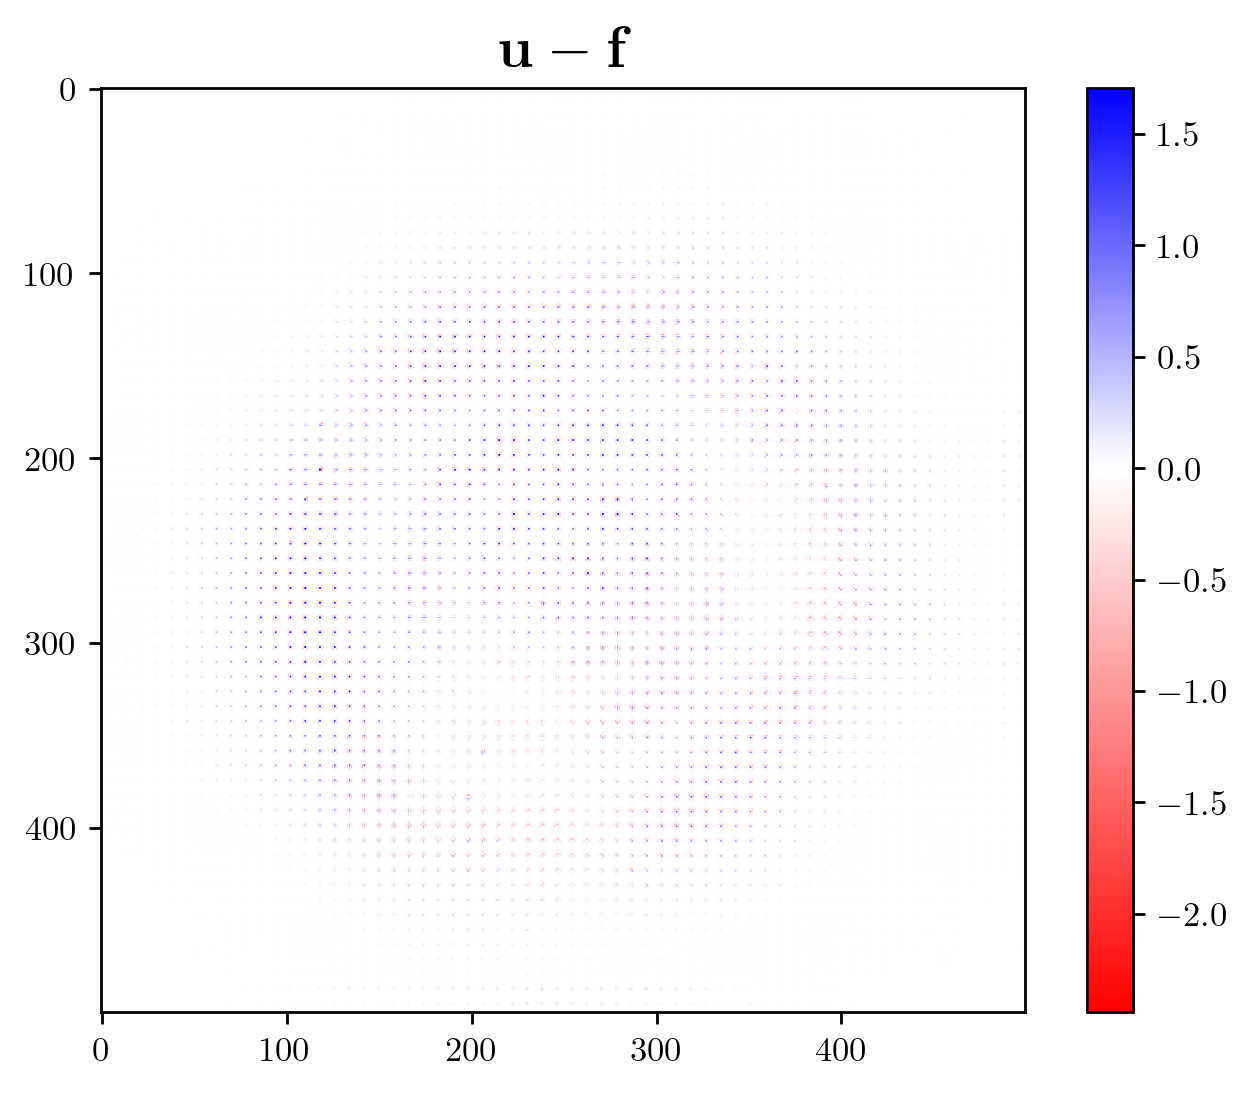

In [150]:

from scipy.ndimage import gaussian_filter


smoothed_truth = torch.tensor(gaussian_filter(y.cpu().detach().numpy(),sigma=20)).to(device)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"

})

plt.figure(dpi=250)
import matplotlib


red = np.array([1,0,0])
white = np.array([1,1,1])
blue = np.array([0,0,1])

colors = []
for i in np.linspace(0,1,100):
    colors.append(  (1-i) * red + (i) * white)             
for i in np.linspace(0,1,70):
    colors.append(  (1-i) * white + (i) * blue)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", colors)




diff = ((y[0,0] - yhat_affine[0,0])).detach().cpu().numpy()

vmax_diff = np.abs(diff).max()



plt.imshow(diff,cmap=cmap,vmax = vmax_diff*0.7,vmin=-vmax_diff); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{f}$',fontsize=17)

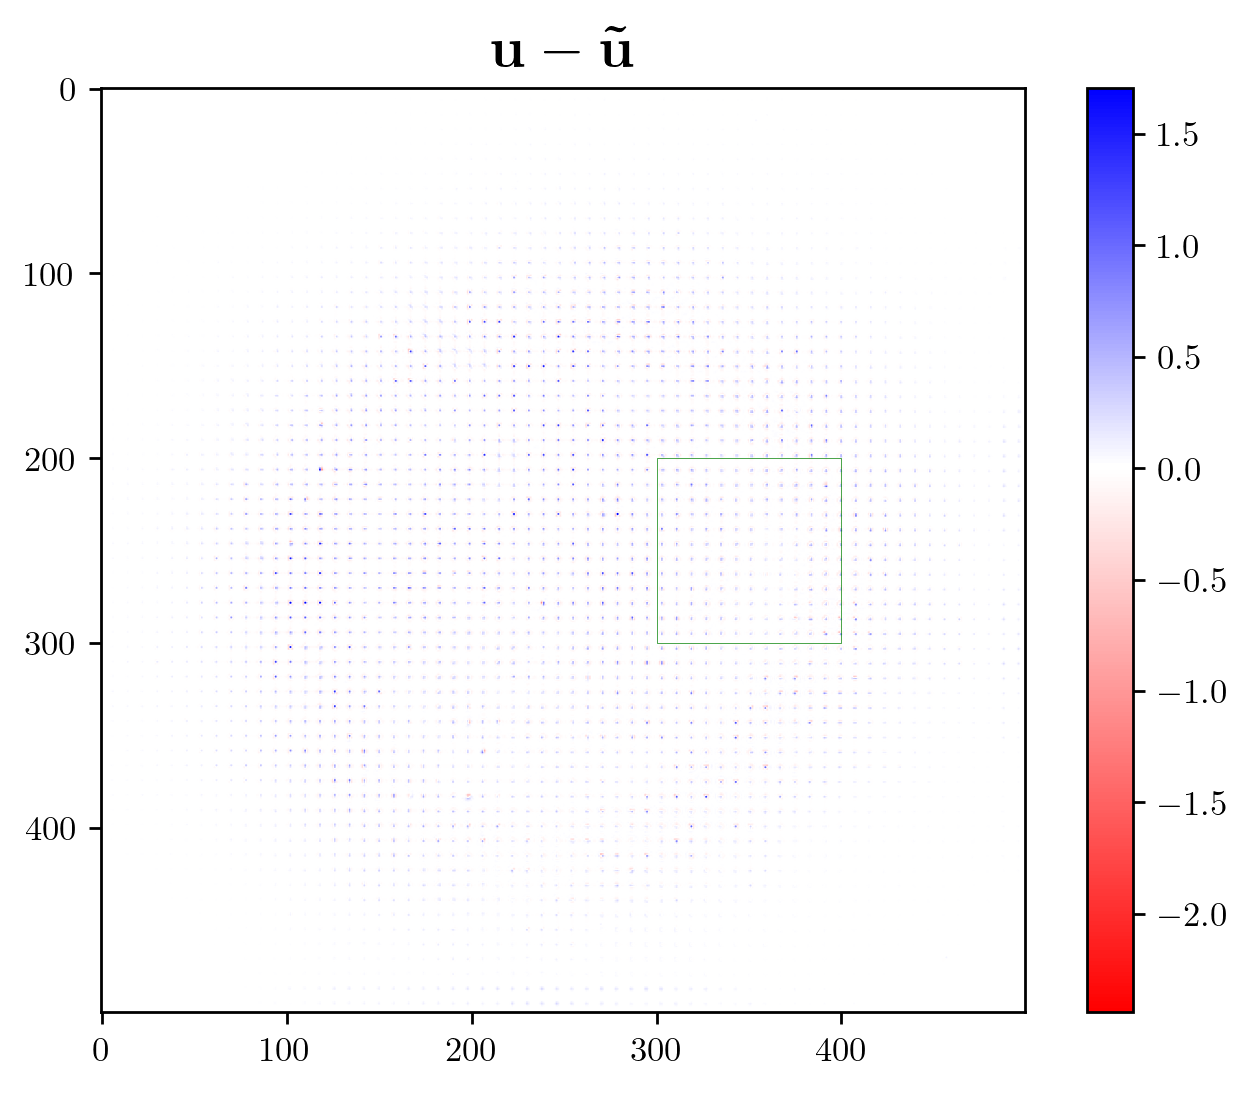

In [151]:
#import patches from matplotlib



from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle


smoothed_truth = torch.tensor(gaussian_filter(y.cpu().detach().numpy(),sigma=20)).to(device)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.figure(dpi=250)
import matplotlib



diff = ((y[0,0] - yhat[0,0])).detach().cpu().numpy()

# vmax_diff = np.abs(diff).max()
#import patches



plt.imshow(diff,cmap=cmap,vmax = vmax_diff*0.7,vmin=-vmax_diff); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{\tilde{u}}$',fontsize=17)
# plt.imshow(diff,cmap='RdBu',vmax = vmax_diff,vmin=-vmax_diff); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{\tilde{u}}$',fontsize=17)
rect = Rectangle((300, 200), 100, 100, linewidth=0.2, edgecolor='g', facecolor='none')
plt.gca().add_patch(rect)


Text(0.5, 1.0, '$\\mathbf{u} - \\mathbf{\\tilde{u}}$')

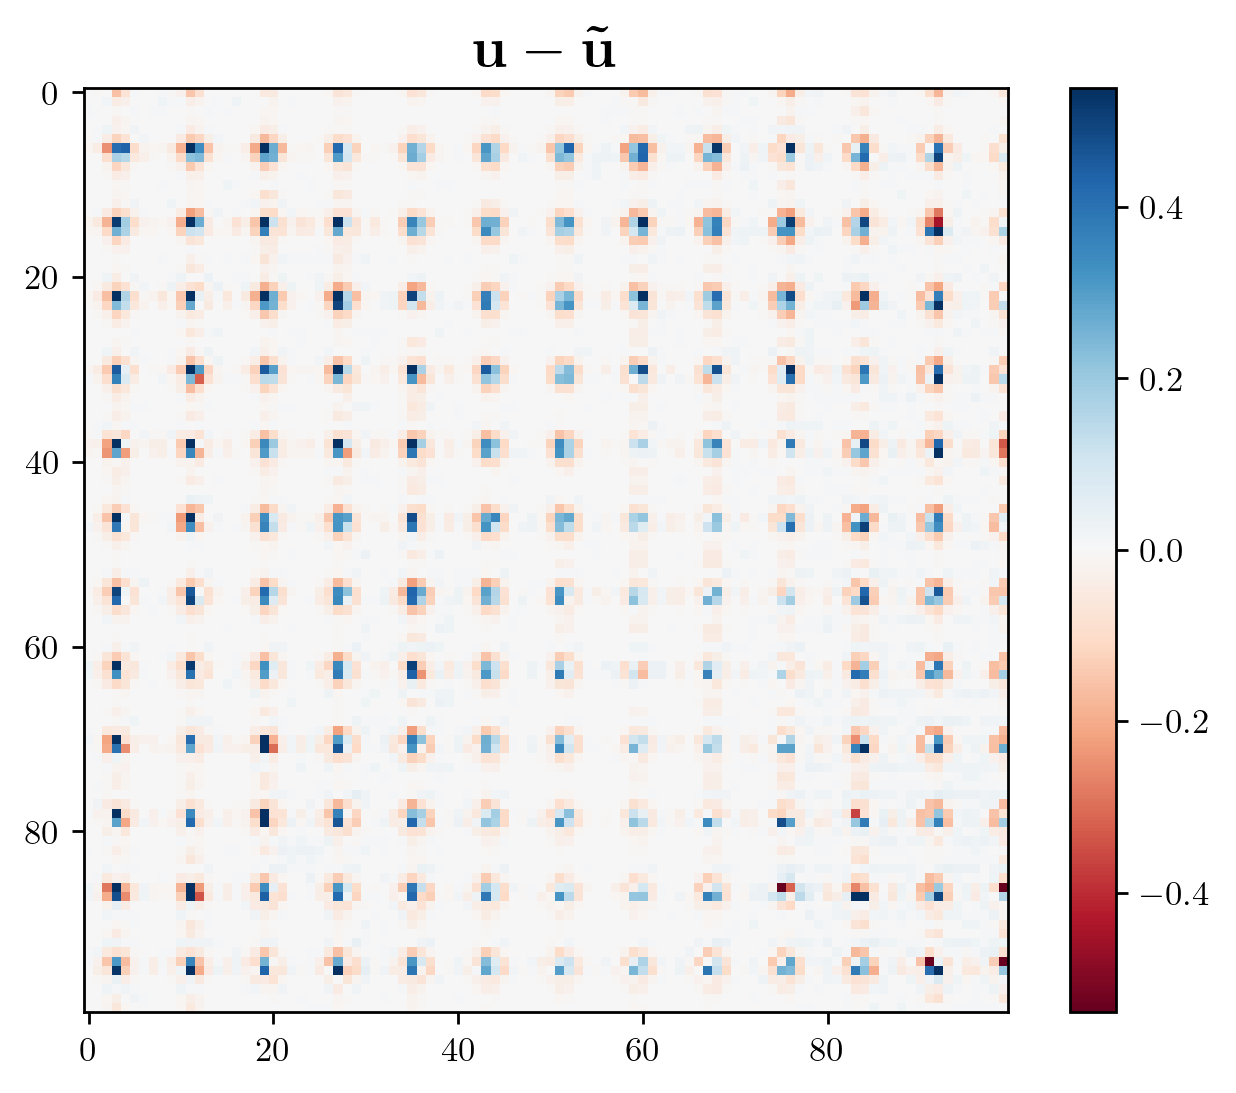

In [152]:
from scipy.ndimage import gaussian_filter

plt.figure(dpi=250)

vmax = abs(diff[200:300,300:400]).max()

plt.imshow(diff[200:300,300:400],cmap='RdBu',vmax = vmax*0.5,vmin=-vmax*0.5); plt.colorbar(); plt.title(r'$\mathbf{u} - \mathbf{\tilde{u}}$',fontsize=17)


In [73]:
2**8

256

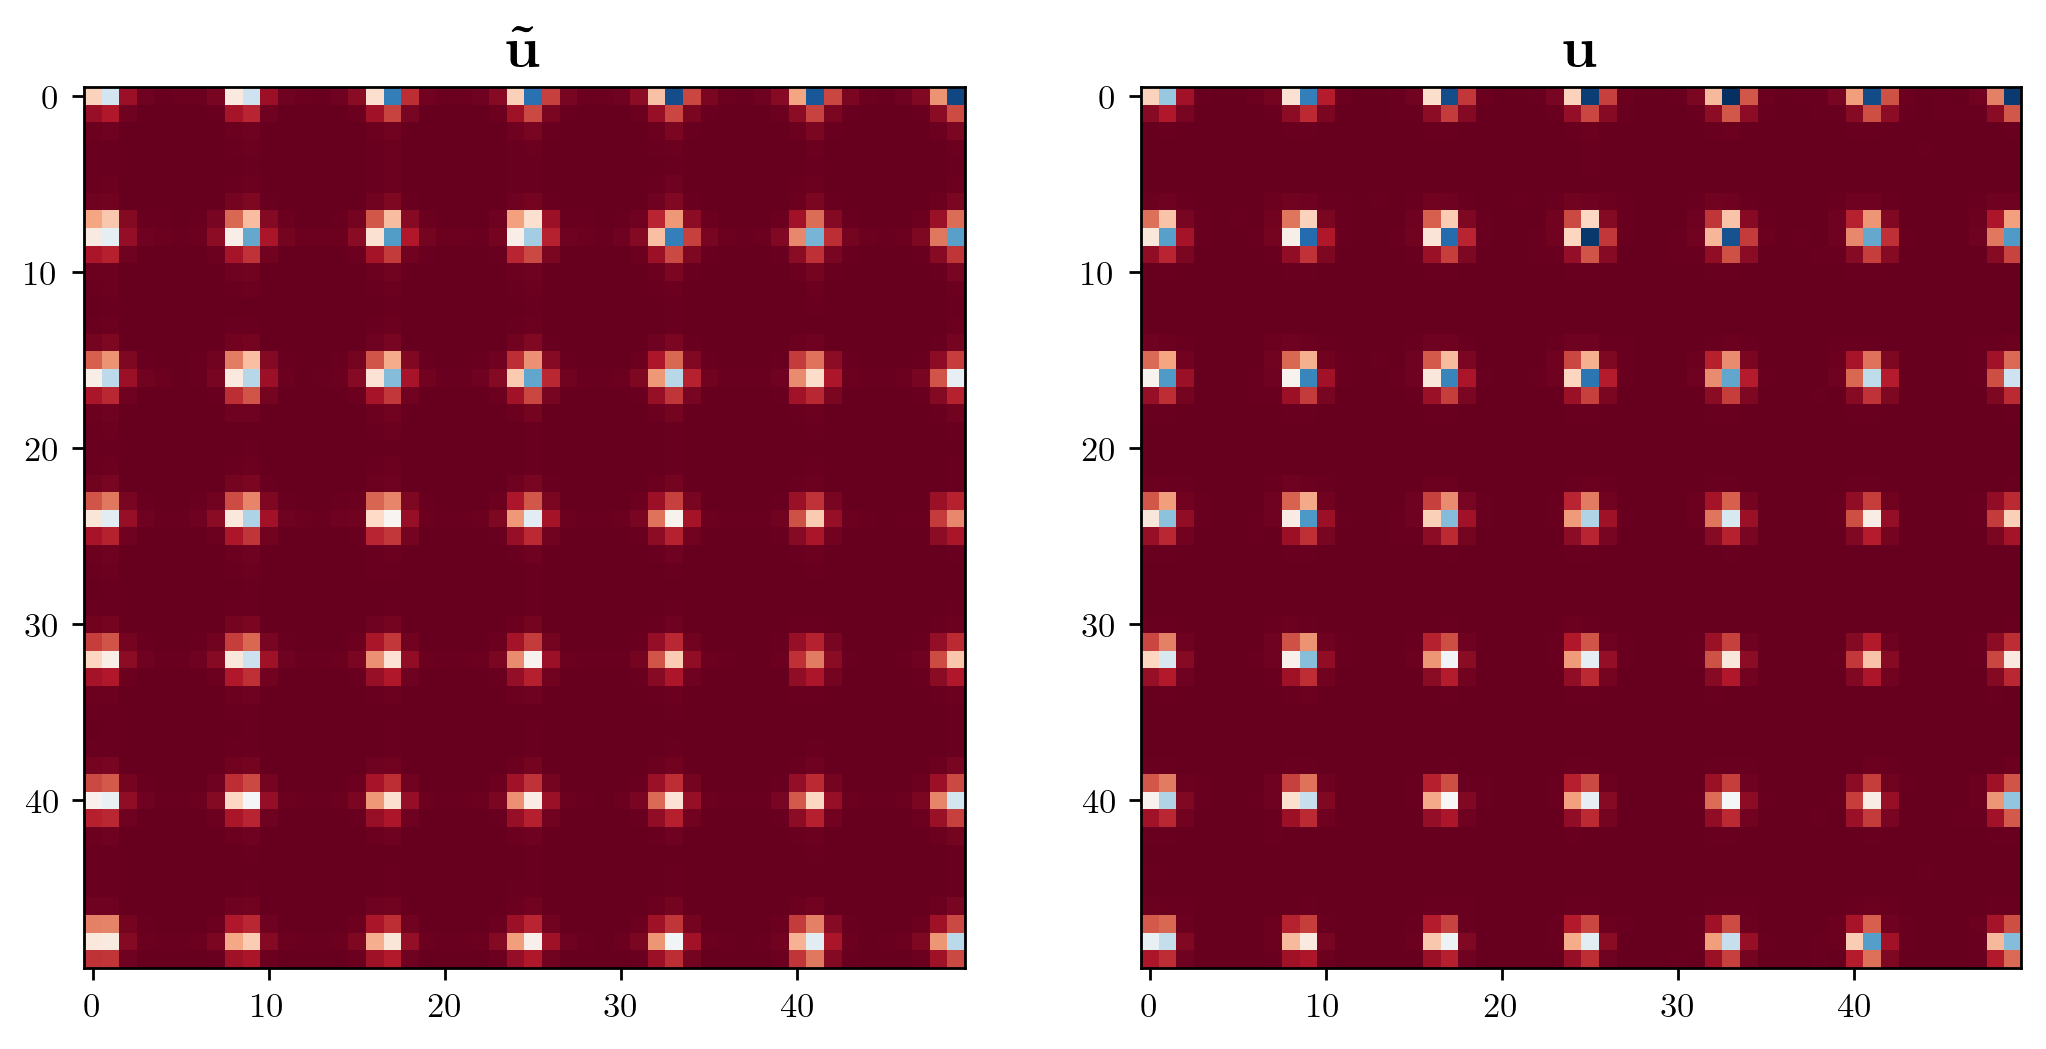

In [87]:
fig,ax = plt.subplots(1,2,figsize=(10,5),dpi=250)

vmax = y[0,0,150:200,150:200].cpu().detach().max()

ax[0].imshow((yhat)[0,0,150:200,150:200].cpu().detach(),vmax=vmax,cmap='RdBu'); ax[0].set_title(r'$\mathbf{\tilde{u}}$',fontsize=17)
ax[1].imshow(y[0,0,150:200,150:200].cpu().detach(),vmax=vmax,cmap='RdBu'); ax[1].set_title(r'$\mathbf{u}$',fontsize=17)
# rect = Rectangle((30, 0), 10, 10, linewidth=0.3, edgecolor='k', facecolor='none')
# ax[0].add_patch(rect)
# ax[1].add_patch(rect)
plt.show()

True:  max: 4.99385404586792, mean:  0.20407576858997345, max_proportion: 0.38235291838645935
Pred:  max: 3.4172821044921875, mean:  0.20394036173820496, max_proportion: 0.2618168890476227


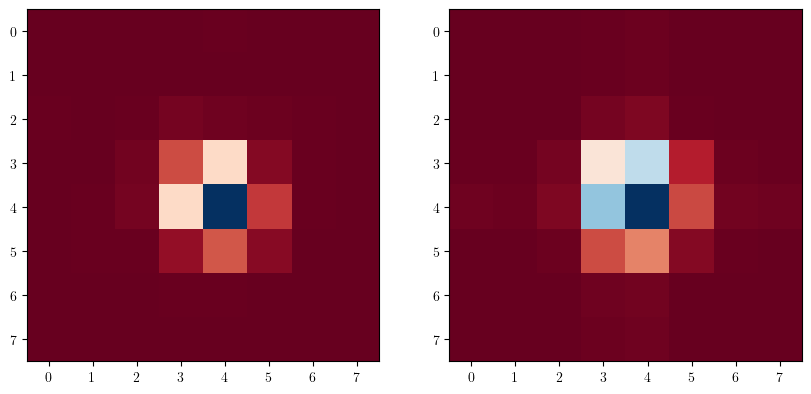

In [88]:
x_pos = 154
y_pos = 171

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(y[0,0,x_pos:x_pos+8,y_pos:y_pos+8].cpu().detach(),cmap='RdBu')
ax[1].imshow(yhat[0,0,x_pos:x_pos+8,y_pos:y_pos+8].cpu().detach(),cmap='RdBu')

print(f'True:  max: {y[0,0,x_pos:x_pos+8,y_pos:y_pos+8].cpu().detach().numpy().max()}, mean:  {y[0,0,x_pos:x_pos+8,y_pos:y_pos+8].cpu().detach().numpy().mean()}, max_proportion: {y[0,0,x_pos:x_pos+8,y_pos:y_pos+8].cpu().detach().max()/y[0,0,x_pos:x_pos+8,y_pos:y_pos+8].cpu().detach().sum()}')
print(f'Pred:  max: {yhat[0,0,x_pos:x_pos+8,y_pos:y_pos+8].cpu().detach().numpy().max()}, mean:  {yhat[0,0,x_pos:x_pos+8,y_pos:y_pos+8].cpu().detach().numpy().mean()}, max_proportion: {yhat[0,0,x_pos:x_pos+8,y_pos:y_pos+8].cpu().detach().max()/yhat[0,0,x_pos:x_pos+8,y_pos:y_pos+8].cpu().detach().sum()}')

In [ ]:
y[0,0,x_pos:x_pos+8,y_pos:y_pos+8]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0220, 0.0110, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0220, 0.0000, 0.0329, 0.0988, 0.0768, 0.0439, 0.0220, 0.0110],
        [0.0000, 0.0000, 0.0878, 0.8671, 2.0085, 0.2085, 0.0329, 0.0000],
        [0.0000, 0.0220, 0.0988, 1.9975, 4.9939, 0.7354, 0.0329, 0.0000],
        [0.0000, 0.0220, 0.0220, 0.3073, 0.9439, 0.2305, 0.0110, 0.0000],
        [0.0000, 0.0110, 0.0000, 0.0329, 0.0329, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0110, 0.0000, 0.0000, 0.0110, 0.0000, 0.0000, 0.0000]],
       device='cuda:1')

In [ ]:
6 / 0.01

600.0

In [ ]:
yhat[0,0,x_pos:x_pos+8,y_pos:y_pos+8]

tensor([[5.2779e-04, 5.6622e-04, 1.6806e-03, 1.4908e-02, 3.3987e-02, 5.9539e-03,
         8.7597e-04, 5.0869e-04],
        [5.7440e-04, 5.4074e-04, 2.2472e-03, 2.0345e-02, 4.4457e-02, 7.3920e-03,
         8.3642e-04, 6.0301e-04],
        [1.4761e-03, 2.2028e-03, 9.7904e-03, 8.6041e-02, 1.8130e-01, 2.8796e-02,
         3.2603e-03, 2.0465e-03],
        [1.2274e-02, 1.9117e-02, 9.2576e-02, 8.5637e-01, 1.7632e+00, 2.7162e-01,
         3.0210e-02, 1.7749e-02],
        [3.4597e-02, 5.1307e-02, 2.3582e-01, 2.1481e+00, 4.4265e+00, 6.8202e-01,
         7.8630e-02, 5.0904e-02],
        [6.7633e-03, 1.0262e-02, 4.7921e-02, 4.3692e-01, 9.0181e-01, 1.3933e-01,
         1.6231e-02, 1.0129e-02],
        [9.8112e-04, 1.0744e-03, 4.3514e-03, 3.8777e-02, 8.0007e-02, 1.2557e-02,
         1.4859e-03, 1.1972e-03],
        [4.7919e-04, 6.1173e-04, 2.5651e-03, 2.3885e-02, 5.0905e-02, 8.3810e-03,
         1.0012e-03, 5.5258e-04]], device='cuda:1', grad_fn=<SliceBackward0>)

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(tensor(1.), tensor(0.2500))

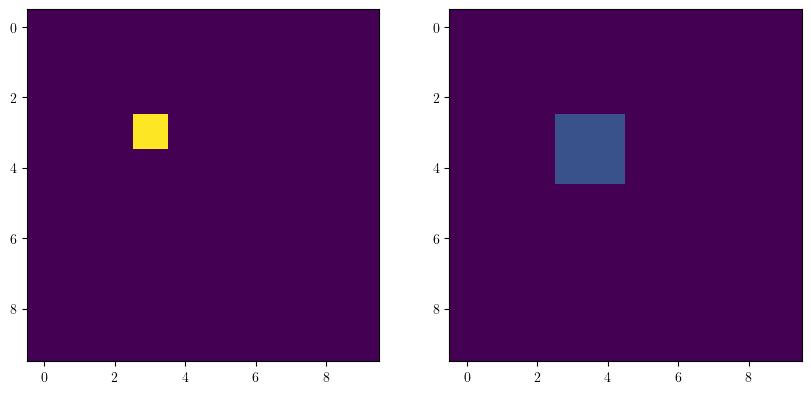

In [ ]:
nx,ny = 10,10
a = torch.zeros((nx,ny))
a[3,3] = 1

px_space = 2/nx

xx = torch.linspace(-1 + px_space/2,1 - px_space/2,nx)
yy = torch.linspace(-1 + px_space/2,1 - px_space/2,ny)
# yy = torch.linspace(-1,1,ny)
xx,yy = torch.meshgrid(xx,yy)
grid = torch.cat((xx.unsqueeze(-1),yy.unsqueeze(-1)),dim=-1).unsqueeze(0).to(torch.float32)

grid-= px_space*0.5


final = F.grid_sample(a.unsqueeze(0).unsqueeze(0),grid)

fig,ax = plt.subplots(1,2,figsize=(10,5))

vmax, vmin = a.max(), a.min()

ax[0].imshow(a)
ax[1].imshow(final[0,0],vmax=vmax,vmin=vmin)

a.max(),final.max()